In [4]:
import gym
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from tensorboardX import SummaryWriter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(4, 64)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, 2)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


env = gym.make('CartPole-v1')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

onlineQNetwork = QNetwork().to(device)
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)

GAMMA = 0.99
EXPLORE = 20000
INITIAL_EPSILON = 0.1
FINAL_EPSILON = 0.0001
REPLAY_MEMORY = 50000
BATCH = 16

UPDATE_STEPS = 4

memory_replay = Memory(REPLAY_MEMORY)

epsilon = INITIAL_EPSILON
learn_steps = 0
writer = SummaryWriter('logs/ddqn')
begin_learn = False

episode_reward = 0
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)
for epoch in count():

    state = env.reset()
    episode_reward = 0
    for time_steps in range(200):
        p = random.random()
        if p < epsilon:
            action = random.randint(0, 1)
        else:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = onlineQNetwork.select_action(tensor_state)
        env.render()
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        memory_replay.add((state, next_state, action, reward, done))
        if memory_replay.size() > 128:
            if begin_learn is False:
                begin_learn = True
            learn_steps += 1
            if learn_steps % UPDATE_STEPS == 0:
                targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
            batch = memory_replay.sample(BATCH, False)
            batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

            batch_state = torch.FloatTensor(batch_state).to(device)
            batch_next_state = torch.FloatTensor(batch_next_state).to(device)
            batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            with torch.no_grad():
                onlineQ_next = onlineQNetwork(batch_next_state)
                targetQ_next = targetQNetwork(batch_next_state)
                online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True)
                y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, online_max_action.long())

            loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            writer.add_scalar('loss', loss.item(), global_step=learn_steps)

            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        if done:
            break
    
        state = next_state
    scores_window.append(episode_reward)       # save most recent score
    scores.append(episode_reward)              # save most recent score

    writer.add_scalar('episode reward', episode_reward, global_step=epoch)
    if epoch % 100 == 0:
        print('Ep {}\tMoving average score: {:.2f}\t'.format(epoch, np.mean(scores_window)))
    if np.mean(scores_window)>=195.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(epoch-100, np.mean(scores_window)))
        torch.save(onlineQNetwork.state_dict(), 'checkpoint_duel.pth')
        break
env.close()

Ep 0	Moving average score: 37.00	
Ep 100	Moving average score: 21.78	
Ep 200	Moving average score: 55.27	

Environment solved in 193 episodes!	Average Score: 195.22


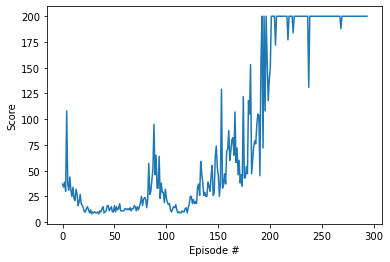

In [7]:
import matplotlib.pyplot as plt
# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

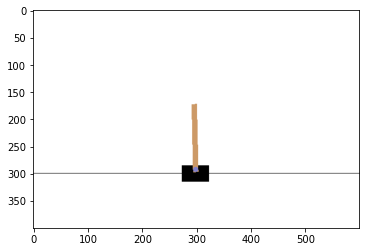

In [13]:
# load the weights from file
onlineQNetwork.state_dict(torch.load('checkpoint_duel.pth'))
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
